**Práctica 3 parte 1 Manuela Santamaria Andrés Felipe Agudelo Omar Santiago Acevedo**

El análisis de señales EEG permite identificar patrones eléctricos que pueden reflejar diferencias funcionales entre poblaciones neurológicas. En este trabajo se analizó la energía promedio de señales EEG multicanal, comparando dos grupos: sujetos sanos (control) y pacientes con enfermedad de Parkinson, con el objetivo de identificar canales con diferencias estadísticamente significativas.

El primer paso fue cargar el archivo .zip y descomprimirlo

In [ ]:
from google.colab import files
import zipfile
import os

# Primero, sube un .zip con ambas carpetas (control y parkinson)
uploaded = files.upload()

# Descomprimir
for filename in uploaded.keys():
    if filename.endswith('.zip'):
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall("/content/")
            print(f"Descomprimido {filename}")


Saving datos_senales_datos_parkinson_cursos.zip to datos_senales_datos_parkinson_cursos (1).zip
Descomprimido datos_senales_datos_parkinson_cursos (1).zip


Aquí se define una función para automatizar la lectura de múltiples archivos EEG desde una carpeta específica. Se asume que cada archivo contiene las señales EEG de un sujeto.

Ademas se organizan los datos crudos y se les da estructura, se muestra información relevante como la forma y la cantidad de pacientes.

In [ ]:
import scipy.io
import numpy as np
import pandas as pd
import os

# Lee todos los archivos .mat de una carpeta y extrae la señal EEG y Retorna una lista con arreglos de forma (canales, muestras, épocas)
def cargar_senales(carpeta):
    archivos = [f for f in os.listdir(carpeta) if f.endswith('.mat')]
    señales = []

    for archivo in archivos:
        ruta = os.path.join(carpeta, archivo)
        mat = scipy.io.loadmat(ruta)

        # Busca una variable que contenga 'EEG' o similar (ajustar si se sabe el nombre exacto)
        for key in mat.keys():
            if not key.startswith("__") and isinstance(mat[key], np.ndarray):
                if mat[key].ndim == 3:  # esperamos (canales, muestras, épocas)
                    señales.append(mat[key])
                    break

    return señales

print(f"Número de pacientes en el grupo CONTROL: {len(señales_control)}")
print(f"Número de pacientes en el grupo PARKINSON: {len(señales_parkinson)}")

# Forma de las señales (canales, muestras, épocas)
print("\nForma de la señal de un paciente del grupo CONTROL:")
print(señales_control[0].shape)

print("\nForma de la señal de un paciente del grupo PARKINSON:")
print(señales_parkinson[0].shape)

Número de pacientes en el grupo CONTROL: 36
Número de pacientes en el grupo PARKINSON: 23

Forma de la señal de un paciente del grupo CONTROL:
(8, 2000, 166)

Forma de la señal de un paciente del grupo PARKINSON:
(8, 2000, 149)


**Comparación estadística de Energía de señales EEG**
1. Calcular la energía promedio de cada canal

se define la función que permite calcular el pormedio de energía de cada canal siguiendo la ecuación

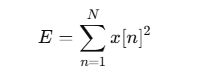

Se recorre cada época del EEG.

Para cada época, se obtiene una matriz
epoca
∈
𝑅
𝐶
×
𝑀
epoca∈R
C×M
 , donde:

𝐶: número de canales,

𝑀: número de muestras por época.

Luego se calcula la energía por canal en esa época como:

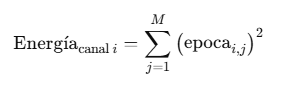

Esta energía se acumula canal por canal a lo largo de las épocas.

Se reduce la señal EEG tridimensional a una representación compacta (vector de energías por canal) para anlizarla como una variable cuantitativa y crear su DataFrame

In [ ]:
#  Calcula la energía por canal, promediada por épocas
#  Entrada: señal EEG (canales, muestras, épocas)
#  Salida: vector de energía promedio por canal
def energia_por_canal(señal):
    canales, muestras, epocas = señal.shape
    energia_canal = np.zeros(canales)

    for e in range(epocas):
        epoca = señal[:, :, e]
        energia_canal += np.sum(epoca ** 2, axis=1)  # sumamos por muestras en cada canal

    return energia_canal / epocas


Analisis estadistico (Punto 2 y 3)



*   Se definen las rutas donde están almacenadas las señales EEG de cada grupo poblacional: pacientes sanos (grupo control) y pacientes con enfermedad de Parkinson.

*   Se utiliza la función cargar_senales() (explicada antes) para obtener una lista de señales por grupo. Cada elemento de estas listas es una matriz tridimensional correspondiente a un sujeto, con dimensiones(canal, muestras,epocas)


*   Para cada señal, se aplica la función ***energia_por_canal()*** y se obtiene un vector de energía promedio por canal

*   Se define el data frame





In [ ]:
# Rutas
ruta_control = "/content/control"
ruta_parkinson = "/content/parkinson"

# Cargar señales
señales_control = cargar_senales(ruta_control)
señales_parkinson = cargar_senales(ruta_parkinson)

# Calcular energía por sujeto
energia_control = [energia_por_canal(s) for s in señales_control]
energia_parkinson = [energia_por_canal(s) for s in señales_parkinson]

# Convertir a DataFrames
df_control = pd.DataFrame(energia_control)
df_parkinson = pd.DataFrame(energia_parkinson)

df_control.columns = [f"Canal_{i+1}" for i in range(df_control.shape[1])]
df_parkinson.columns = [f"Canal_{i+1}" for i in range(df_parkinson.shape[1])]

df_control.index.name = 'Sujeto'
df_parkinson.index.name = 'Sujeto'


Para identificar diferencias significativas entre ellos: Primero, calcula la energía promedio por canal para cada sujeto en ambos grupos y verifica la normalidad de los datos mediante la prueba de Shapiro-Wilk. Luego, evalúa la homocedasticidad (igualdad de varianzas) entre los grupos usando la prueba de Levene. Dependiendo de los resultados, se aplica el t-test si ambos grupos son normales y tienen varianzas homogéneas, o la prueba U de Mann-Whitney si no se cumplen esos supuestos. Los p-valores obtenidos de estas pruebas indican si existen diferencias significativas en la energía de los canales entre los grupos. Finalmente, los resultados se organizan y presentan en un DataFrame, ordenados por p-valor, lo que permite identificar qué canales contienen diferencias informativas clave entre los pacientes con Parkinson y los controles sanos, facilitando la interpretación de patrones EEG característicos.

In [ ]:
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu
import matplotlib.pyplot as plt

# Energía promedio por canal
energia_media_control = df_control.mean()
energia_media_parkinson = df_parkinson.mean()

resultados = []

for canal in df_control.columns:
    x = df_control[canal]
    y = df_parkinson[canal]

    # Prueba de normalidad
    stat_shapiro_x, p_shapiro_x = shapiro(x)
    stat_shapiro_y, p_shapiro_y = shapiro(y)

    normal_x = p_shapiro_x > 0.05
    normal_y = p_shapiro_y > 0.05

    # Homocedasticidad (igual varianza)
    stat_levene, p_levene = levene(x, y)
    iguales_varianzas = p_levene > 0.05

    if normal_x and normal_y and iguales_varianzas:
        # t-test
        stat, p = ttest_ind(x, y)
        metodo = 't-test'
    else:
        # Mann-Whitney
        stat, p = mannwhitneyu(x, y, alternative='two-sided')
        metodo = 'Mann-Whitney'

    resultados.append({
        'Canal': canal,
        'Normal_Control': normal_x,
        'Normal_Parkinson': normal_y,
        'Homocedasticidad': iguales_varianzas,
        'Método': metodo,
        'p-valor': p
    })

df_resultados = pd.DataFrame(resultados)

print("Energía por canal - Grupo Control:")
display(df_control)

print("Energía por canal - Grupo Parkinson:")
display(df_parkinson)

print(shapiro(x))

# Mostrar tabla de resultados estadísticos
print("Resultados del análisis estadístico:")
display(df_resultados.sort_values("p-valor"))


Energía por canal - Grupo Control:


,Canal_1,Canal_2,Canal_3,Canal_4,Canal_5,Canal_6,Canal_7,Canal_8
Sujeto,,,,,,,,
0,4915.062778,6105.849947,5167.552339,4137.717862,4103.995281,20359.586331,17598.962585,22292.230470
1,11840.210442,26452.547613,15211.335701,12976.758727,14377.091900,7215.202754,15864.901097,19472.869878
2,32321.272932,37703.798749,42613.972372,29252.410036,26890.856667,68243.618642,52417.921598,72115.850131
3,54139.262123,49105.618777,53194.129654,57224.244039,56824.702656,239662.908728,194882.004020,381633.958654
4,17567.465030,21738.511853,29429.308030,28530.200793,24586.407386,73273.828899,68753.985484,67962.795266
5,11920.628977,12381.108138,11545.897906,11616.229122,18658.417865,42058.456657,34417.780679,46167.748438
6,33100.991142,37083.630148,48210.820005,37758.393155,28343.182930,101170.614692,87824.803410,137143.924875
7,21064.909655,17704.075393,18305.622532,22438.444791,22415.119998,43344.591885,36731.812513,45890.820535
8,9702.573235,8310.599134,11274.177917,7138.981899,10286.070527,16151.490459,15731.296585,20956.719846


Energía por canal - Grupo Parkinson:


,Canal_1,Canal_2,Canal_3,Canal_4,Canal_5,Canal_6,Canal_7,Canal_8
Sujeto,,,,,,,,
0,23658.738825,23990.255991,30633.745996,22888.894132,19932.315538,65161.432397,60552.834862,58441.048743
1,14532.459483,17860.192841,30120.983497,29569.273094,30054.971601,22088.181162,18262.518633,18454.068489
2,9581.810471,14008.572615,9589.230257,9374.085669,8154.941858,28970.848994,40705.897395,36624.858559
3,16202.416566,13124.247855,13988.674335,12752.027365,15784.724049,50730.233172,50742.237835,73694.061647
4,31133.326257,21899.992984,17153.107641,20533.434338,31864.375631,79797.786103,74152.811380,66497.823839
5,29402.195610,31214.592172,30663.970154,24697.341514,25296.654765,67961.116232,74866.179511,103522.441839
6,12438.243570,11261.175800,10819.634775,9489.784462,12091.060945,22798.213463,23700.620349,25606.065340
7,33900.139101,32395.467750,29194.827407,23439.114082,25040.406700,122738.018441,103327.500981,100845.843964
8,16001.606312,13678.099220,16024.473570,14482.116106,14723.843472,31443.053250,28191.962386,33117.421322


ShapiroResult(statistic=np.float64(0.7170924317963812), pvalue=np.float64(5.307787994214454e-07))
Resultados del análisis estadístico:


,Canal,Normal_Control,Normal_Parkinson,Homocedasticidad,Método,p-valor
6,Canal_7,False,False,True,Mann-Whitney,0.118301
7,Canal_8,False,False,True,Mann-Whitney,0.150544
3,Canal_4,False,False,True,Mann-Whitney,0.234462
5,Canal_6,False,False,True,Mann-Whitney,0.280075
0,Canal_1,False,False,True,Mann-Whitney,0.405701
2,Canal_3,False,False,True,Mann-Whitney,0.460373
4,Canal_5,False,False,True,Mann-Whitney,0.560018
1,Canal_2,False,False,True,Mann-Whitney,0.570528


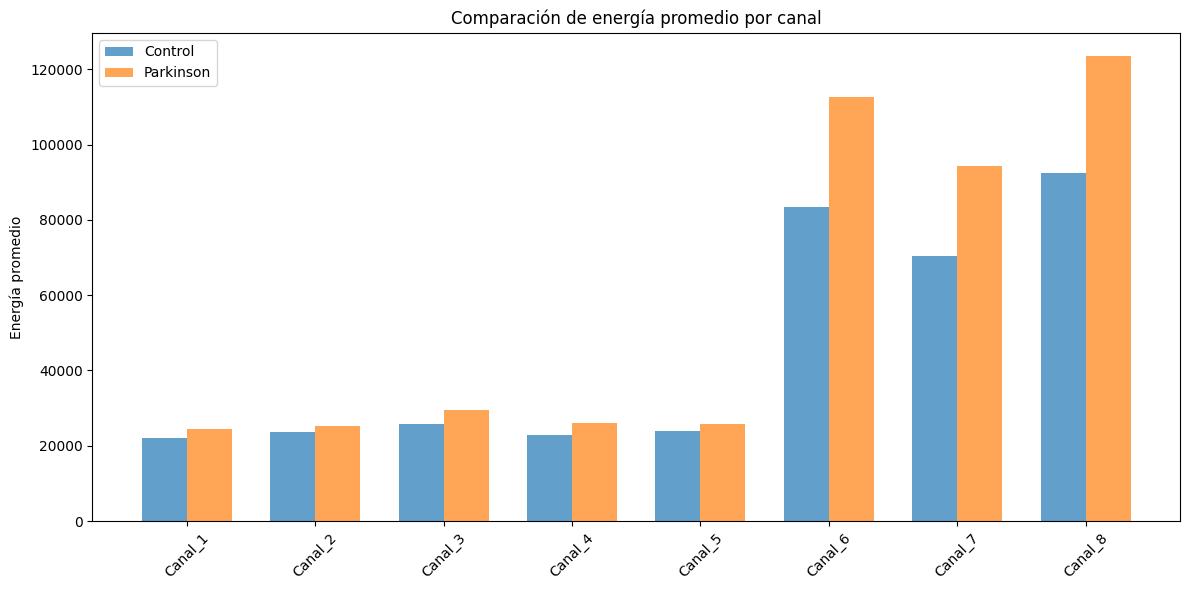

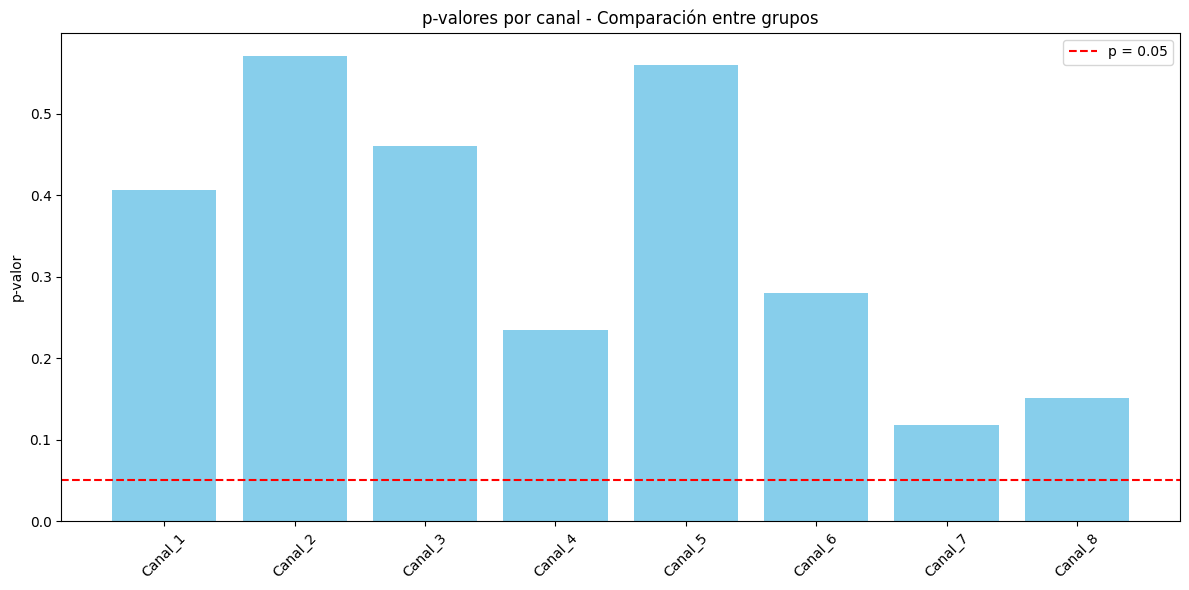

In [ ]:
# Gráfico
# Energía promedio por canal
energia_media_control = df_control.mean()
energia_media_parkinson = df_parkinson.mean()

# Número de canales
n_canales = len(energia_media_control)
indices = np.arange(n_canales)  # Posiciones para las barras
ancho = 0.35  # Ancho de cada barra

# Crear gráfico
plt.figure(figsize=(12, 6))
plt.bar(indices - ancho/2, energia_media_control, width=ancho, label='Control', alpha=0.7)
plt.bar(indices + ancho/2, energia_media_parkinson, width=ancho, label='Parkinson', alpha=0.7)

# Etiquetas
plt.xticks(indices, df_control.columns, rotation=45)
plt.ylabel('Energía promedio')
plt.title('Comparación de energía promedio por canal')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.bar(df_resultados['Canal'], df_resultados['p-valor'], color='skyblue')
plt.axhline(y=0.05, color='red', linestyle='--', label='p = 0.05')
plt.xticks(rotation=45)
plt.ylabel('p-valor')
plt.title('p-valores por canal - Comparación entre grupos')
plt.legend()
plt.tight_layout()
plt.show()